# Example 4 (Multiple LRCs in one type)

In this tutorial, we will demonstrate the basic use of MetaChat using simulated data generated by the PDE model. In this example, we set up a situation where multiple LRCs of one type exist at the same time. We assume that the metabolite `M1` can communicate with proximal cells by short-range diffusion and with distal cells by long-range channel transport (`type1`).

<img src="../../_static/image/example1.jpg" alt="Example1" width="100"/>

In [1]:
# Importing packages
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt

import metachat as mc

To run the examples, you'll need to download the some pre-existing files in `docs/tutorials/simulated_data` folder and change your working directory to the toy_example folder.

In [12]:
# setting work dictionary
os.chdir("your_path/simulated_data")

## Data preprocessing

In [3]:
adata = sc.read("data/example4/adata_example4.h5ad")
adata

AnnData object with n_obs × n_vars = 2500 × 2
    obsm: 'spatial'

This dataset consists of a metabolite `M1` and a sensor `S1`. Their spatial distributions are shown below:

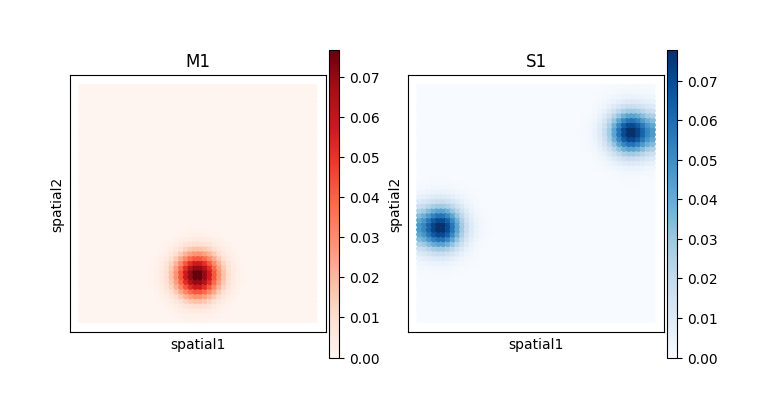

In [4]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))
sq.pl.spatial_scatter(adata = adata,
                      color = "M1",
                      size = 80,
                      cmap = "Reds",
                      shape = None,
                      ax = ax[0])
ax[0].invert_yaxis()
ax[0].set_box_aspect(1)

sq.pl.spatial_scatter(adata = adata,
                      color = "S1",
                      size = 80,
                      cmap = "Blues",
                      shape = None,
                      ax = ax[1])
ax[1].invert_yaxis()
ax[1].set_box_aspect(1)
plt.show()

## MCC Inference

### Metabolite-sensor database construction

We need to artificially create a simple database which must include three columns: `Metabolite`, `Sensor`, `Long.Range.Channel`, representing the metabolite name, the sensor name, and the type of long range channel that metabolites may be entered, respectively.

In [5]:
M_S_pair = [['M1', 'S1', 'type1']]
df_metasen = pd.DataFrame(M_S_pair)
df_metasen.columns = ['Metabolite', 'Sensor', 'Long.Range.Channel']

### Long-range channels (LRC)

Import the pre-defined long range channel and add it to the `adata` object.

In [6]:
LRC_channel = np.load('data/example4/LRC_channel.npy')
adata.obs['LRC_type1_filtered'] = LRC_channel.flatten()
adata.obs['LRC_type1_filtered'] = adata.obs['LRC_type1_filtered'].astype('category')

It's spatial distribution are shown in orange color:

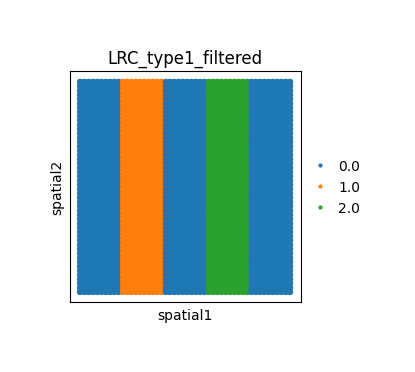

In [8]:
fig, ax = plt.subplots(figsize = (3,3))
sq.pl.spatial_scatter(adata = adata,
                      color = "LRC_type1_filtered",
                      size = 80,
                      shape = None,
                      ax = ax)
ax.invert_yaxis()
ax.set_box_aspect(1)
plt.show()

### Compute the cost matrix based on the long-range channels

To utilize flow-optimal transport, we need to compute the cost matrix depends mainly on two parameters:maximum communication distance (dis_thr) and long-range communication strength (LRC_strength).

Compute spatial cost distance without long-range channel...
Compute spatial cost distance incorporating long-range channel of type1
The points that can occur long-range communication is...


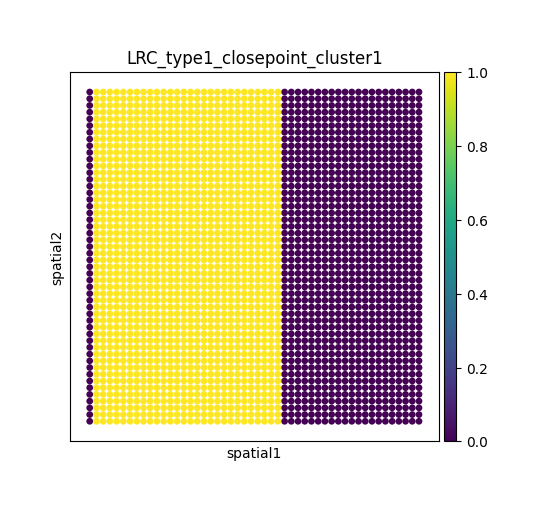

The points that can occur long-range communication is...


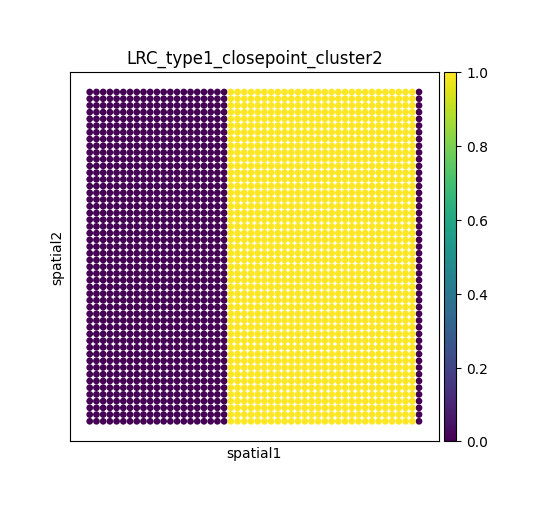

  Construct network graph of long-range channel among 5 neighborhoods...
  Calculate the shortest path distance from the source to the target using the shortest path algorithm...
    For the long-range case of cluster 1...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:57<00:00,  2.10it/s]


    For the long-range case of cluster 2...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:55<00:00,  2.12it/s]


  Rearrange distance matrix...
    For the long-range case of cluster 1...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1400/1400 [00:05<00:00, 262.38it/s]


    For the long-range case of cluster 2...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1400/1400 [00:05<00:00, 263.22it/s]

Finished!


In [9]:
mc.pp.compute_costDistance(adata = adata,
                           LRC_type = ["type1"],
                           dis_thr = 10,
                           k_neighb = 5,
                           LRC_strength = 4,
                           plot = True,
                           spot_size = 1)

### Run the inference function

In [10]:
mc.tl.metabolic_communication(adata = adata,
                              database_name = 'msdb_example4',
                              df_metasen = df_metasen,
                              LRC_type = ["type1"],
                              dis_thr = 15,
                              fot_weights = (1.0,0.0,0.0,0.0),
                              fot_eps_p = 0.25,
                              fot_rho = 1.0,
                              cost_type = 'euc')

There are 1 pairs were found from the spatial data.


### Compare MetaChat results with the PDE model

Comparative results showed that the distribution of `M1-S1` inferred by MetaChat had a high correlation with that simulated by the PDE model.

In [15]:
MCC_PDE = np.load('data/example4/pde_result.npy')
MCC_infer = adata.obsm['MetaChat-msdb_example4-sum-receiver']['r-M1-S1'].values.reshape(50,50)

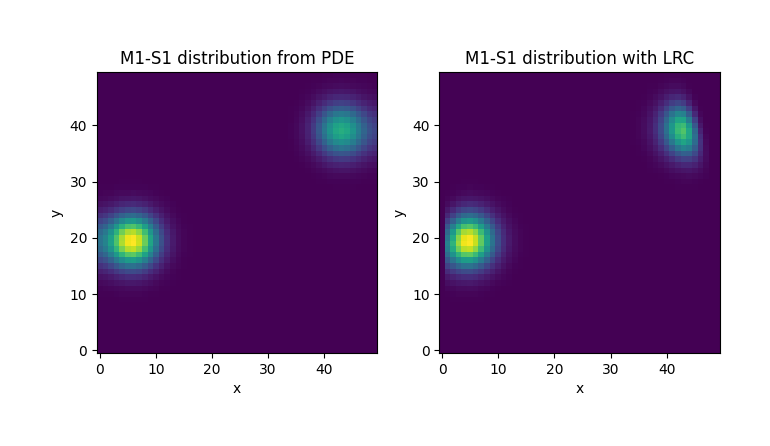

In [16]:
fig, ax = plt.subplots(1,2, figsize = (7,14))
ax[0].imshow(MCC_PDE[2].T, cmap='viridis', origin='lower')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('M1-S1 distribution from PDE')
ax[0].set_box_aspect(1)
ax[1].imshow(MCC_infer.T, cmap='viridis', origin='lower')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('M1-S1 distribution with LRC')
ax[1].set_box_aspect(1)
plt.tight_layout()